## Welcome!

Before running everything, check that you have everything that needs to be imported.
If you lack something, you can create a new block code after this, and use for all the items needed the command <br />
`%pip install MISSING_LIBRARY_NAME -q`

In [67]:
# Basic Python imports
import os
from os.path import normpath, basename
import shutil
from collections import Counter

# Torch related import
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# Everything else
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [16]:
PRJ_ROOT = '.'
DATA_ROOT = os.path.join(PRJ_ROOT, 'data')
DATA_ZIP = os.path.join(DATA_ROOT, 'geometry_dataset.zip')
DATA_PATH = os.path.join(DATA_ROOT, 'geometry_dataset')

print('Directories\n')
print(f'Project Root: {PRJ_ROOT}')
print(f'Data Root: {DATA_ROOT}')
print(f'Data Zip: {DATA_ZIP}')
print(f'Data Dataset: {DATA_PATH}')

Directories

Project Root: .
Data Root: .\data
Data Zip: .\data\geometry_dataset.zip
Data Dataset: .\data\geometry_dataset


Before doing anything else, we need to extract the dataset from the zip file `data/geometry_dataset.zip`. <br />
If for some reasons there's any king of problem with this, simply extract it manually into the folder `data`.

In [13]:
shutil.unpack_archive(DATA_ZIP, DATA_ROOT)

In [18]:
def subdir_counts(folder):
    counts = {}
    for root, dirs, files in os.walk(folder, topdown=False):
        if len(files)>0:
            short_root = basename(normpath(root))
            counts[short_root]=len(files)
    return counts

In [25]:
print('Number of files in data folder\n')
counts = subdir_counts(DATA_PATH)

for typ, count in counts.items():
    print(f'{typ}: ' + ('\t' if len(typ)>=6 else '\t\t') + f'{count}')

Number of files in data folder

Circle: 	10000
Heptagon: 	10000
Hexagon: 	10000
Nonagon: 	10000
Octagon: 	10000
Pentagon: 	10000
Square: 	10000
Star: 		10000
Triangle: 	10000


# Dataset

In [26]:
DATA_PATH = os.path.join(DATA_ROOT, 'geometry_dataset')

### Dataset preprocessing
Thankfully there's not much to do in this section, we only need to normalize the images when are loaded into the dataset object. <br />
To do that we use the `transforms.Normalize()` function,

In [28]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
dataset = torchvision.datasets.ImageFolder(DATA_PATH, transform=transform)

In [29]:
classes = dataset.classes

In [30]:
def imshow(data, classes):
    img, label_idx = data
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.title(classes[label_idx])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

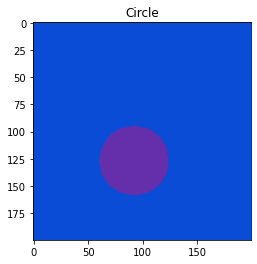

In [31]:
imshow(dataset[0], classes)

In [32]:
dataset[0][0].numpy().shape

(3, 200, 200)

### Train-Test Split

In [33]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2

In [34]:
indices = list(range(len(dataset)))
targets = dataset.targets

train_val_indices,test_indices = train_test_split(indices,test_size=TEST_SIZE, stratify=targets)

In [35]:
class ImageSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, labels):
        self.dataset = torch.utils.data.Subset(dataset, indices)
        self.targets = labels
        
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        target = self.targets[idx]
        return (image, target)
        
    def __len__(self):
        return len(self.targets)

In [36]:
train_val_set = ImageSubset(dataset, train_val_indices, np.array(targets)[train_val_indices])
test_set      = ImageSubset(dataset, test_indices, np.array(targets)[test_indices])

In [73]:
def count_classes(dataset, classes):
    for c, count in sorted(dict(Counter(dataset.targets)).items()):
        print(f'{classes[c]}:' + ('\t' if len(classes[c])>6 else '\t\t') + f'{count}')

In [76]:
print('Distribution of classes in train_val_set\n')
count_classes(train_val_set, classes)

Distribution of classes in train_val_set

Circle:		8000
Heptagon:	8000
Hexagon:	8000
Nonagon:	8000
Octagon:	8000
Pentagon:	8000
Square:		8000
Star:		8000
Triangle:	8000


In [77]:
print('Distribution of classes in test_set\n')
count_classes(test_set, classes)

Distribution of classes in test_set

Circle:		2000
Heptagon:	2000
Hexagon:	2000
Nonagon:	2000
Octagon:	2000
Pentagon:	2000
Square:		2000
Star:		2000
Triangle:	2000


Now we need to still divide the train_val dataset into a pure *training set* and into a *validation set*

In [40]:
train_val_indices = list(range(len(train_val_set)))
train_val_targets = train_val_set.targets

train_indices, val_indices = train_test_split(train_val_indices, test_size=VAL_SIZE, stratify=train_val_targets)

In [41]:
train_set = ImageSubset(train_val_set, train_indices, np.array(train_val_targets)[train_indices])
val_set = ImageSubset(train_val_set, val_indices, np.array(train_val_targets)[val_indices])

In [42]:
print('Distribution of classes in train_set')
count_classes(train_set, classes)

Distribution of classes in train_set
Circle: 6400
Heptagon: 6400
Hexagon: 6400
Nonagon: 6400
Octagon: 6400
Pentagon: 6400
Square: 6400
Star: 6400
Triangle: 6400


In [43]:
print('Distribution of classes in val_set')
count_classes(val_set, classes)

Distribution of classes in val_set
Circle: 1600
Heptagon: 1600
Hexagon: 1600
Nonagon: 1600
Octagon: 1600
Pentagon: 1600
Square: 1600
Star: 1600
Triangle: 1600


### Hyperparameters

In [53]:
BATCH_SIZE = 32
NUM_WORKERS = 0

LEARNING_RATE = 0.001

EPOCHS = 12
PRINT_EVERY = 10
VALID_LOSS_MIN = np.Inf

MODEL_PATH = os.path.join(PRJ_ROOT, 'model')
if 'model' not in os.listdir(PRJ_ROOT):
    os.makedirs(MODEL_PATH)

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataloader

In [46]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dl   = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dl  = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

### Model

In [47]:
class Net(nn.Module):
    def __init__(self): 
        super().__init__()
        # Convoution layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Max Pooling layer
        self.pool = nn.MaxPool2d(4, 4)

        # Fully connected layers
        self.fc1 = nn.Linear(1936, 200)
        self.fc2 = nn.Linear(200, 84)
        self.fc3 = nn.Linear(84, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1936, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)

### Training

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [49]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
model = net
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dl)

for epoch in range(1, EPOCHS+1):
    running_loss = 0.0
    correct = 0
    total=0

    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dl):
        data_, target_ = data_.to(device), target_.type(torch.LongTensor).to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)

        if (batch_idx) % 20 == 0:
            print(f'Epoch [{epoch}/{EPOCHS}], Step [{batch_idx}/{total_step}], Loss: {loss.item():.4f}')

    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')

    batch_loss = 0
    total_t=0
    correct_t=0

    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_dl):
            data_t, target_t = data_t.to(device), target_t.type(torch.LongTensor).to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)

        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(val_dl))
        network_learned = batch_loss < VALID_LOSS_MIN
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')

    # Saving the best weight
    if network_learned:
        VALID_LOSS_MIN = batch_loss
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, f'model_state_epoch_{epoch}.pt'))
        print('Detected network improvement, saving current model')
    
    model.train()

print('\nTraining Complete!')

In [55]:
metrics = [train_loss, train_acc, val_loss, val_acc]

textfile = open("metrics.txt", "w")

for metric in metrics:
    for e in metric:
        textfile.write(str(e) + " ")
    textfile.write("\n")
textfile.close()

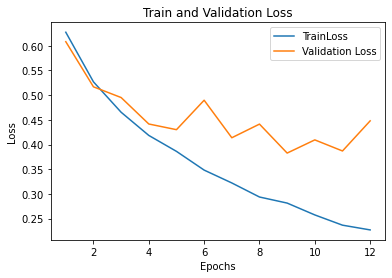

In [62]:
sns.lineplot(x=list(range(1,13)), y=train_loss, legend='brief', label='TrainLoss')
sns.lineplot(x=list(range(1,13)), y=val_loss, legend='brief', label='Validation Loss')

plt.title("Train and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.savefig('loss.png')
plt.show()

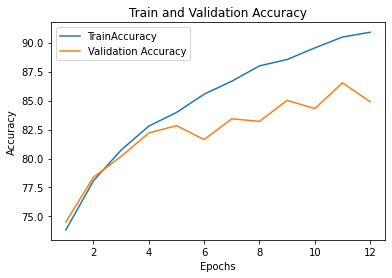

In [61]:
sns.lineplot(x=list(range(1,13)), y=train_acc, legend='brief', label='TrainAccuracy')
sns.lineplot(x=list(range(1,13)), y=val_acc, legend='brief', label='Validation Accuracy')

plt.title("Train and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.savefig('acc.png')
plt.show()


### Evaluation

In [63]:
BEST_EPOCH = 9
PATH = os.path.join(MODEL_PATH, f'model_state_epoch_{BEST_EPOCH}.pt')

In [64]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1936, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)

In [65]:
correct = 0
total = 0

# Since we're not training, we don't need to calculate the gradients for our
outputs
with torch.no_grad():
    for data in test_dl:
        images, labels = data[0].to(device), data[1].to(device)

        # Calculate outputs by running images through the network
        outputs = net(images)
        
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 18000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 18000 test images: 85 %


In [66]:
# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Again no gradients needed
with torch.no_grad():
    for data in test_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Accuracy for class Circle is: 93.0 %
Accuracy for class Heptagon is: 72.9 %
Accuracy for class Hexagon is: 86.5 %
Accuracy for class Nonagon is: 76.8 %
Accuracy for class Octagon is: 65.5 %
Accuracy for class Pentagon is: 83.1 %
Accuracy for class Square is: 93.0 %
Accuracy for class Star  is: 99.1 %
Accuracy for class Triangle is: 97.3 %
